# The ML Pipeline for a Model to Predict Length of Hospital Delivery Stay

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
from math import ceil
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import PredefinedSplit

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost

# Gather Data

In [2]:
# specifying data types for the columns to maintain formatting from original data
data_types = {
    'hospital_service_area': object, 
    'hospital_county': object,
    'operating_certificate_number': object, 
    'permanent_facility_id': object,
    'facility_name': object, 
    'age_group': object, 
    'zip_code_3_digits': object, 
    'gender': object, 
    'race': object,
    'ethnicity': object, 
    'payment_typology_1': object, 
    'payment_typology_2': object,
    'payment_typology_3': object, 
    'length_of_stay': int
}

In [3]:
all_visits = pd.read_csv('../data/planned_deliveries.csv', dtype=data_types)
all_visits = all_visits.loc[:, all_visits.columns != 'Unnamed: 0']
y = all_visits['length_of_stay']
X = all_visits.loc[:, all_visits.columns != 'length_of_stay']

# Compute Baseline Score

In [4]:
mean_length_of_stay = np.mean(y)
median_length_of_stay = np.median(y)
print('Mean length of stay:', mean_length_of_stay)
print('Median length of stay:', median_length_of_stay)

Mean length of stay: 2.3057860029780897
Median length of stay: 2.0


In [5]:
y_pred_mean = pd.Series([mean_length_of_stay]*len(y))

#### RMSE [days]

In [6]:
baseline_rmse = mean_squared_error(y, y_pred_mean, squared=False)
print('Baseline RMSE [days]:', baseline_rmse)

Baseline RMSE [days]: 0.9016674407635193


# Split, Train, and Cross Validate - RMSE Evaluation Metric

### Set up functions for automated pipeline

In [7]:
def stratified_continuous_split(X:pd.DataFrame, y:pd.Series, train_size:float, val_size:float, test_size:float, random_state:int):
    '''
    Performs a stratified split of inputted data (with respect to y) into a training set, validation set, and test set to specified percentages 
    of the data using verstack's scsplit and performs basic error checking.

    Parameters:
    - X: a 2D pandas DataFrame, the feature matrix
    - y: a 1D pandas Series, the target variable matrix matching X
    - train_size: a float between 0 and 1, the percentage of X which should be training data
    - val_size: a float between 0 and 1, the percentage of X which should be reserved for validation
    - test_size: a float between 0 and 1, the percentage of X which should be reserved for final testing
    - random_state: an int, the random state to split with
    Note: The sum of train_size + val_size + test_size must be 1.0 (100% of X).

    Returns:
    - (X_train) a 2D pandas DataFrame, the feature matrix of training data
    - (y_train) a 1D pandas Series, the target variable matrix for training data
    - (X_val) a 2D pandas DataFrame, the feature matrix of validation data
    - (y_val) a 1D pandas Series, the target variable matrix for validation data
    - (X_test) a 2D pandas DataFrame, the feature matrix of testing data
    - (y_test) a 1D pandas Series, the target variable matrix for testing data

    Raises:
    - ValueError for invalid input
    '''
    from verstack.stratified_continuous_split import scsplit
    
    if ((train_size + val_size + test_size) != 1):
        raise ValueError('Your train_size + val_size + test_size must add up to 1 (100%)!')
    if (not isinstance(random_state, int)):
        raise ValueError('Your random_state must be an int!')

    X_train, X_other, y_train, y_other = scsplit(X, y, stratify=y, test_size=(1-train_size), random_state=random_state)
    
    X_len = X.shape[0]
    test_percent_of_other = (test_size * X_len)/(X_len - (train_size * X_len))
    X_other = X_other.reset_index(drop=True)
    y_other = y_other.reset_index(drop=True)
    
    X_val, X_test, y_val, y_test = scsplit(X_other, y_other, stratify=y_other, test_size=test_percent_of_other, random_state=random_state)

    # basic error checking to check that split returned train, val, and test of expected sizes
    train_count_low = (int)(train_size * X_len)
    train_count_high = ceil(train_size * X_len)
    val_count_low = (int)(val_size * X_len)
    val_count_high = ceil(val_size * X_len)
    test_count_low = (int)(test_size * X_len)
    test_count_high = ceil(test_size * X_len)
    
    Xtrain_fin = X_train.shape[0]
    ytrain_fin = y_train.shape[0]
    Xval_fin = X_val.shape[0]
    yval_fin = y_val.shape[0]
    Xtest_fin = X_test.shape[0]
    ytest_fin = y_test.shape[0]
    
    if not (((Xtrain_fin == train_count_low) or (Xtrain_fin == train_count_high)) and ((ytrain_fin == train_count_low) or (ytrain_fin == train_count_high))):
        raise ValueError(f'Training set size should be approx. {train_size * X_len}, instead is: {X_train.shape[0]}')
    if not (((Xval_fin == val_count_low) or (Xval_fin == val_count_high)) and ((yval_fin == val_count_low) or (yval_fin == val_count_high))):
        raise ValueError(f'Validation set size should be approx. {val_size * X_len}, instead is: {X_val.shape[0]}')
    if not (((Xtest_fin == test_count_low) or (Xtest_fin == test_count_high)) and ((ytest_fin == test_count_low) or (ytest_fin == test_count_high))):
        raise ValueError(f'Test set size should be approx. {test_size * X_len}, instead is: {X_test.shape[0]}')
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
def MLpipe_Stratified_Continous_RMSE(X, y, preprocessor, ML_algo, param_grid, xgb=False):
    '''
    This function splits the data to train, validation, and test (60/20/20).
    The RMSE is minimized in cross-validation.
    
    This function:
    1. Loops through 10 different random states
    2. Splits the data 60/20/20.
    3. Fits a model with the predefined Preprocessor, trains the model with each hyperparameter combination in param_grid
    4. Calculates the model's error on the test set on the model with the best hyperparameter combinations in param_grid
    5. Returns a list of 10 test scores and 10 best models

    Arguments:
    - X: a 2D pandas DataFrame, the raw (not preprocessed) feature matrix
    - y: a 1D pandas Series, the raw (not preprocessed) target variable matrix matching X
    - preprocessor: a ColumnTransformer to use for preprocessing X
    - ML_algo: an initialized supervised machine learning algorithm;
               currently supports linear regression, random forest regression, SVR, and XGBoost regressor models
    - param_grid: a dictionary matching ML_algo parameters to a list of values to try in hyperparameter tuning,
                  keys must be formatted with prefix of the algorithm's name followed by two underscores
    - xgb: a boolean with default value False, if the ML model is an XGBoost model or not

    Returns:
    - (test_scores) a list of the 10 best models' test scores (1 for each random state)
    - (best_models) a list of the 10 best models of type ML_algo (1 for each random state)
    - (test_Xs) a list of the 10 DataFrames of test feature matricies corresponding to the test scores returned
    - (test_ys) a list of the 10 Series of true target variable values corresponding to the test scores returned
    '''
    
    # lists to be returned
    test_scores = []
    best_models = []
    test_Xs = []
    test_ys = []

    nr_states = 10
    for i in range(nr_states):
        rs = 28 * i
        print('Random State:', rs)

        # split
        X_train, y_train, X_val, y_val, X_test, y_test = stratified_continuous_split(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=rs)

        # preprocess
        X_train_prep = preprocessor.fit_transform(X_train)
        X_val_prep = preprocessor.transform(X_val)
        X_test_prep = preprocessor.transform(X_test)
        prep_1_ftrs = preprocessor.get_feature_names_out()
        X_train_prep = pd.DataFrame(X_train_prep, columns=prep_1_ftrs)
        X_val_prep = pd.DataFrame(X_val_prep, columns=prep_1_ftrs)
        X_test_prep = pd.DataFrame(X_test_prep, columns=prep_1_ftrs)

        # final preprocess with Standard Scaler so that I can use the coefficients of linear models as global importance metrics
        standard_scaler_transformer = Pipeline(steps=[
            ('std', StandardScaler())])
        final_preprocessor = ColumnTransformer(
            transformers=[('std', standard_scaler_transformer, preprocessor.get_feature_names_out())])
        
        X_train_prep = final_preprocessor.fit_transform(X_train_prep)
        X_val_prep = final_preprocessor.transform(X_val_prep)
        X_test_prep = final_preprocessor.transform(X_test_prep)

        prep_ftrs = final_preprocessor.get_feature_names_out()
        X_test_prep = pd.DataFrame(X_test_prep, columns=prep_ftrs)
        test_Xs.append(X_test_prep)
        test_ys.append(y_test)

        # train and perform cross-validation        
        models = []
        val_scores = []
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            if (xgb):
                clf = ML_algo.fit(X_train_prep, y_train, early_stopping_rounds=50, eval_set=[(X_val_prep, y_val)], verbose=False)
            else:
                clf = ML_algo.fit(X_train_prep, y_train)
            models.append(clf)
            y_val_pred = clf.predict(X_val_prep)
            val_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))

        # save results
        print('    Best Model Parameters:', ParameterGrid(param_grid)[np.argmin(val_scores)])
        print('    Validation Set RMSE:', np.min(val_scores))
        best_model_this_rs = models[np.argmin(val_scores)]
        best_models.append(best_model_this_rs)
        y_test_pred = best_model_this_rs.predict(X_test_prep)
        test_score = mean_squared_error(y_test, y_test_pred, squared=False)
        test_scores.append(test_score)
        mean_length_of_stay = np.mean(y_test)
        print('    Baseline RMSE (test set):', mean_squared_error(y_test, pd.Series([mean_length_of_stay]*len(y_test))))
        print('    Test RMSE:', test_score)
    return test_scores, best_models, prep_ftrs, test_Xs, test_ys

### Run and Cross Validate Several Models - RMSE

In [9]:
def unique_non_nans(X, ftr):
    '''
    Determines the unique, non-nan values of a certain feature in a feature matrix.
    Does not error check that ftr is in fact a column in X; this is the responsibility of the caller.
    
    - X: a 2D DataFrame feature matrix containing the feature of interest as a column
    - ftr: a string, the name of the feature to explore in X
    
    Returns:
    - (unique_vals_nonull) a list of the unique, non-null values of ftr in X, replacing a nan value with 'not reported'
    '''
    unique_vals = X[ftr].unique()
    unique_vals_nonull = ['not reported' if isinstance(x, float) and np.isnan(x) else x for x in unique_vals]

    return unique_vals_nonull    

In [10]:
random_state = 42

# categorizing the columns in my dataset by how they should be encoded
onehot_ftrs = ['hospital_service_area', 'hospital_county', 'operating_certificate_number', 'permanent_facility_id', \
               'facility_name', 'zip_code_3_digits', 'gender', 'race', 'ethnicity', 'payment_typology_1', \
               'payment_typology_2', 'payment_typology_3']
onehot_cats = [unique_non_nans(X, ftr) for ftr in onehot_ftrs]
ordinal_ftrs = ['age_group']
ordinal_cats = [['0 to 17', '18 to 29', '30 to 49', '50 to 69', '70 or Older']]

# replace missing values in categorical columns with 'not reported'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='not reported')),
    ('onehot', OneHotEncoder(categories=onehot_cats, sparse=False, handle_unknown='ignore'))])

# my data has no missing values in its ordinal column, so only encoding is necessary
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', categorical_transformer, onehot_ftrs),
        ('ordinal', ordinal_transformer, ordinal_ftrs)])

In [11]:
# keeping track of scores
models_rmses = pd.DataFrame(columns=['RMSE', 'l1', 'l2', 'Elastic Net', 'Random Forest Regressor', 'SVR', 'XGBoost Regressor'])
models_rmses['RMSE'] = pd.Series(['mean', 'std dev'])
models_rmses = models_rmses.set_index('RMSE')

#### (1) Linear Regression with l1 Regularization

In [15]:
lin_reg_l1 = Lasso(random_state=random_state)
l1_params = {
    'lasso__alpha': np.logspace(math.exp(-2), math.exp(2), 21)
}
l1_test_scores, l1_best_models, l1_test_Xs, l1_test_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=lin_reg_l1, param_grid=l1_params)

Random State: 0
    Best Model Parameters: {'lasso__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8935949027356813
    Baseline RMSE (test set): 0.8209483679920447
    Test RMSE: 0.9060625652325364
Random State: 28
    Best Model Parameters: {'lasso__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8943722755526549
    Baseline RMSE (test set): 0.8023362967344005
    Test RMSE: 0.8957330448081982
Random State: 56
    Best Model Parameters: {'lasso__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8943724758747483
    Baseline RMSE (test set): 0.7985102425069394
    Test RMSE: 0.8935953196069969
Random State: 84
    Best Model Parameters: {'lasso__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8935953196069968
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.8943724758747483
Random State: 112
    Best Model Parameters: {'lasso__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.9160331114616256
    Baseline RMSE (test set): 0.79989785877

In [16]:
print('****Metrics with l1 Linear Regression:****')
mean = np.mean(l1_test_scores)
std = np.std(l1_test_scores)
models_rmses['l1']['mean'] = mean
models_rmses['l1']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with l1 Linear Regression:****
Mean RMSE: 0.8996183590016958
Std. Deviation of RMSE: 0.005782125870334668


In [17]:
file = open('../results/lin_reg_l1.save', 'wb')
best_model_index = np.argmin(l1_test_scores)
pickle.dump((l1_best_models[best_model_index], l1_test_Xs[best_model_index], l1_test_ys[best_model_index]), file)
file.close()

#### (2) Linear Regression with l2 Regularization

In [14]:
lin_reg_l2 = Ridge(random_state=random_state)
l2_params = {
    'ridge__alpha': np.logspace(math.exp(-2), math.exp(2), 21)
}
l2_test_scores, l2_best_models, prep_ftrs, l2_test_Xs, l2_test_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=lin_reg_l2, param_grid=l2_params)

Random State: 0
    Best Model Parameters: {'ridge__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8748326455657882
    Baseline RMSE (test set): 0.8209483679920447
    Test RMSE: 0.8766151457342722
Random State: 28
    Best Model Parameters: {'ridge__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8663862212169134
    Baseline RMSE (test set): 0.8023362967344005
    Test RMSE: 0.8598233472524134
Random State: 56
    Best Model Parameters: {'ridge__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8625293918481787
    Baseline RMSE (test set): 0.7985102425069394
    Test RMSE: 0.8671131350438647
Random State: 84
    Best Model Parameters: {'ridge__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8577693591578243
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.8607684974498054
Random State: 112
    Best Model Parameters: {'ridge__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8886716828086011
    Baseline RMSE (test set): 0.79989785877

In [15]:
print('****Metrics with l2 Linear Regression:****')
mean = np.mean(l2_test_scores)
std = np.std(l2_test_scores)
models_rmses['l2']['mean'] = mean
models_rmses['l2']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with l2 Linear Regression:****
Mean RMSE: 0.8684211333621802
Std. Deviation of RMSE: 0.006525011341007684


In [16]:
file = open('../results/lin_reg_l2.save', 'wb')
best_model_index = np.argmin(l2_test_scores)
pickle.dump((l2_best_models[best_model_index], prep_ftrs, l2_test_Xs[best_model_index], l2_test_ys[best_model_index]), file)
file.close()

#### (3) Linear Regression with Elastic Net Regularization

In [21]:
lin_reg_elastic = ElasticNet(random_state=random_state)
elastic_params = {
    'elasticnet__alpha': np.logspace(math.exp(-2), math.exp(2), 21),
    'elasticnet__l1_ratio': np.linspace(0, 1, 21)
}
elastic_test_scores, elastic_best_models, elastic_test_Xs, elastic_test_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=lin_reg_elastic, param_grid=elastic_params)

Random State: 0
    Best Model Parameters: {'elasticnet__l1_ratio': 0.0, 'elasticnet__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8865510222531405
    Baseline RMSE (test set): 0.8162659053959312
    Test RMSE: 0.9034748141373455
Random State: 28
    Best Model Parameters: {'elasticnet__l1_ratio': 0.0, 'elasticnet__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8943722755526549
    Baseline RMSE (test set): 0.8023362967344005
    Test RMSE: 0.8957330448081982
Random State: 56
    Best Model Parameters: {'elasticnet__l1_ratio': 0.0, 'elasticnet__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8943724758747483
    Baseline RMSE (test set): 0.7985102425069394
    Test RMSE: 0.8935953196069969
Random State: 84
    Best Model Parameters: {'elasticnet__l1_ratio': 0.0, 'elasticnet__alpha': 1.3656370263406605}
    Validation Set RMSE: 0.8935953196069968
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.8943724758747483
Random State: 112
    Best Model 

In [22]:
print('****Metrics with Elastic Net Linear Regression:****')
mean = np.mean(elastic_test_scores)
std = np.std(elastic_test_scores)
models_rmses['Elastic Net']['mean'] = mean
models_rmses['Elastic Net']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with Elastic Net Linear Regression:****
Mean RMSE: 0.8993595838921766
Std. Deviation of RMSE: 0.0055407996038346575


In [23]:
file = open('../results/lin_reg_elastic_net.save', 'wb')
best_model_index = np.argmin(elastic_test_scores)
pickle.dump((elastic_best_models[best_model_index], elastic_test_Xs[best_model_index], elastic_test_ys[best_model_index]), file)
file.close()

#### (4) Random Forest Regressor

In [24]:
random_forest_reg = RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=random_state)
rf_params = {
    'randomforestregressor__max_features': [1, 3, 10, 30],
    'randomforestregressor__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
rf_test_scores, rf_best_models, rf_test_Xs, rf_test_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=random_forest_reg, param_grid=rf_params)

Random State: 0
    Best Model Parameters: {'randomforestregressor__max_features': 1, 'randomforestregressor__max_depth': 1}
    Validation Set RMSE: 0.9441374245617995
    Baseline RMSE (test set): 0.8162659053959312
    Test RMSE: 0.9435899483633553
Random State: 28
    Best Model Parameters: {'randomforestregressor__max_features': 1, 'randomforestregressor__max_depth': 1}
    Validation Set RMSE: 0.9276978559011436
    Baseline RMSE (test set): 0.8023362967344005
    Test RMSE: 0.9395228578559748
Random State: 56
    Best Model Parameters: {'randomforestregressor__max_features': 1, 'randomforestregressor__max_depth': 1}
    Validation Set RMSE: 0.9266875832294577
    Baseline RMSE (test set): 0.7985102425069394
    Test RMSE: 0.9340469556081087
Random State: 84
    Best Model Parameters: {'randomforestregressor__max_features': 1, 'randomforestregressor__max_depth': 1}
    Validation Set RMSE: 0.9302880909330861
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.925590

In [26]:
print('****Metrics with Random Forest Regression:****')
mean = np.mean(rf_test_scores)
std = np.std(rf_test_scores)
models_rmses['Random Forest Regressor']['mean'] = mean
models_rmses['Random Forest Regressor']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with Random Forest Regression:****
Mean RMSE: 0.9380360833067808
Std. Deviation of RMSE: 0.009226260088414212


In [27]:
file = open('../results/random_forest_regressor.save', 'wb')
best_model_index = np.argmin(rf_test_scores)
pickle.dump((rf_best_models[best_model_index], rf_test_Xs[best_model_index], rf_test_ys[best_model_index]), file)
file.close()

#### (5) Support Vector Regression (SVR)

In [28]:
svr = SVR()
svr_params = {
    'svr__gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5],
    'svr__C': [1e-1, 1e0, 1e1]
}
svr_test_scores, svr_best_models, svr_test_Xs, svr_test_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=svr, param_grid=svr_params)

Random State: 0
    Best Model Parameters: {'svr__gamma': 0.001, 'svr__C': 0.1}
    Validation Set RMSE: 0.8797803091926238
    Baseline RMSE (test set): 0.8162659053959312
    Test RMSE: 0.9038676919455402
Random State: 28
    Best Model Parameters: {'svr__gamma': 0.001, 'svr__C': 0.1}
    Validation Set RMSE: 0.8945910580648586
    Baseline RMSE (test set): 0.8023362967344005
    Test RMSE: 0.8849388528798542
Random State: 56
    Best Model Parameters: {'svr__gamma': 0.001, 'svr__C': 0.1}
    Validation Set RMSE: 0.882540320576815
    Baseline RMSE (test set): 0.7985102425069394
    Test RMSE: 0.8889780059159369
Random State: 84
    Best Model Parameters: {'svr__gamma': 0.001, 'svr__C': 0.1}
    Validation Set RMSE: 0.8772711088587577
    Baseline RMSE (test set): 0.7998978587740607
    Test RMSE: 0.8845531390704332
Random State: 112
    Best Model Parameters: {'svr__gamma': 0.001, 'svr__C': 0.1}
    Validation Set RMSE: 0.9069651467416714
    Baseline RMSE (test set): 0.799897858774

In [29]:
print('****Metrics with Support Vector Regression:****')
mean = np.mean(svr_test_scores)
std = np.std(svr_test_scores)
models_rmses['SVR']['mean'] = mean
models_rmses['SVR']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with Support Vector Regression:****
Mean RMSE: 0.8930520263976515
Std. Deviation of RMSE: 0.008518775192191531


In [30]:
file = open('../results/svr.save', 'wb')
best_model_index = np.argmin(svr_test_scores)
pickle.dump((svr_best_models[best_model_index], svr_test_Xs[best_model_index], svr_test_ys[best_model_index]), file)
file.close()

#### (6) XGBoost

In [31]:
xgb = xgboost.XGBRegressor(seed=0, n_estimators=10000, learning_rate=0.03, colsample_bytree=0.9, subsample=0.66)
xgb_params = {
    'xgbregressor__reg_alpha': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    'xgbregressor__lambda': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    'xgbregressor__max_depth': [1, 3, 10, 30, 100]
}
xgb_test_scores, xgb_best_models, xgb_test_Xs, xgb_test_ys = MLpipe_Stratified_Continous_RMSE(X, y, preprocessor=preprocessor, ML_algo=xgb, param_grid=xgb_params, xgb=True)

Random State: 0
    Best Model Parameters: {'xgbregressor__reg_alpha': 0.0, 'xgbregressor__max_depth': 1, 'xgbregressor__lambda': 0.0}
    Validation Set RMSE: 0.8533812939715202
    Baseline RMSE (test set): 0.83731471791581
    Test RMSE: 0.8865328861920657
Random State: 28
    Best Model Parameters: {'xgbregressor__reg_alpha': 0.0, 'xgbregressor__max_depth': 1, 'xgbregressor__lambda': 0.0}
    Validation Set RMSE: 0.8667595589540853
    Baseline RMSE (test set): 0.8023362967344005
    Test RMSE: 0.8613775376377211
Random State: 56
    Best Model Parameters: {'xgbregressor__reg_alpha': 0.0, 'xgbregressor__max_depth': 1, 'xgbregressor__lambda': 0.0}
    Validation Set RMSE: 0.8607116197532533
    Baseline RMSE (test set): 0.7985102425069394
    Test RMSE: 0.8633416610448467
Random State: 84
    Best Model Parameters: {'xgbregressor__reg_alpha': 0.0, 'xgbregressor__max_depth': 1, 'xgbregressor__lambda': 0.0}
    Validation Set RMSE: 0.859462115711352
    Baseline RMSE (test set): 0.799

In [32]:
print('****Metrics with XGB Regressor:****')
mean = np.mean(xgb_test_scores)
std = np.std(xgb_test_scores)
models_rmses['XGBoost Regressor']['mean'] = mean
models_rmses['XGBoost Regressor']['std dev'] = std
print('Mean RMSE:', mean)
print('Std. Deviation of RMSE:', std)

****Metrics with XGB Regressor:****
Mean RMSE: 0.8687652498802307
Std. Deviation of RMSE: 0.008392727983029266


In [33]:
file = open('../results/xgboost.save', 'wb')
best_model_index = np.argmin(xgb_test_scores)
pickle.dump((xgb_best_models[best_model_index], xgb_test_Xs[best_model_index], xgb_test_ys[best_model_index]), file)
file.close()

### Results

In [34]:
models_rmses

l1        l2 Elastic Net Random Forest Regressor       SVR  \
RMSE                                                                        
mean     0.899618  0.868278     0.89936                0.938036  0.893052   
std dev  0.005782  0.006357    0.005541                0.009226  0.008519   

        XGBoost Regressor  
RMSE                       
mean             0.868765  
std dev          0.008393

# Best Model - Global Interpretability

In [17]:
l2_file = open('../results/lin_reg_l2.save', 'rb')
l2_model, prep_ftrs, X_test, y_test = pickle.load(l2_file)
l2_file.close()

In [18]:
# making tuples to keep feature and corresponding w together
ws = l2_model.coef_
ftr_abs_ws = []
for i in range(0, len(prep_ftrs)):
    ftr_abs_ws.append((prep_ftrs[i], np.abs(ws[i])))
    
# ranking features by the absolute value of their mean coefficient value (w)
sorted_ftrs = sorted(ftr_abs_ws, key=(lambda x: x[1]), reverse=True)
print('Top 10 most important features:')
for i in range(0, 10):
    print(f'{i+1}: {sorted_ftrs[i][0]}')

Top 10 most important features:
1: std__onehot__hospital_county_Nassau
2: std__onehot__hospital_county_Queens
3: std__onehot__hospital_service_area_Long Island
4: std__onehot__operating_certificate_number_2951001
5: std__onehot__facility_name_North Shore University Hospital
6: std__onehot__permanent_facility_id_000541
7: std__onehot__zip_code_3_digits_142
8: std__onehot__hospital_service_area_New York City
9: std__onehot__zip_code_3_digits_136
10: std__onehot__zip_code_3_digits_112


In [19]:
all_visits[all_visits.hospital_county == 'Nassau']

hospital_service_area hospital_county operating_certificate_number  \
20              Long Island          Nassau                      2908000   
51              Long Island          Nassau                      2908000   
89              Long Island          Nassau                      2950002   
90              Long Island          Nassau                      2950002   
92              Long Island          Nassau                      2950002   
...                     ...             ...                          ...   
18669           Long Island          Nassau                      2909000   
18771           Long Island          Nassau                      7003004   
18785           Long Island          Nassau                      7003004   
18786           Long Island          Nassau                      7003004   
18803           Long Island          Nassau                      7003004   

      permanent_facility_id                      facility_name age_group  \
20                   000511   NYU Langone Hospital-Long Island  30 to 49   
51                   000511   NYU Langone Hospital-Long Island  30 to 49   
89                   000528   Nassau University Medical Center  18 to 29   
90                   000528   Nassau University Medical Center  18 to 29   
92                   000528   Nassau University Medical Center  30 to 49   
...                     ...                                ...       ...   
18669                000513                     Mercy Hospital  18 to 29   
18771                001630  Long Island Jewish Medical Center  30 to 49   
18785                001630  Long Island Jewish Medical Center  30 to 49   
18786                001630  Long Island Jewish Medical Center  30 to 49   
18803                001630  Long Island Jewish Medical Center  18 to 29   

      zip_code_3_digits gender        race          ethnicity  \
20                  118      F  Other Race   Spanish/Hispanic   
51                  115      F  Other Race   Spanish/Hispanic   
89                  115      F       White   Spanish/Hispanic   
90                  115      F  Other Race   Spanish/Hispanic   
92                  115      F       White   Spanish/Hispanic   
...                 ...    ...         ...                ...   
18669               115      F  Other Race  Not Span/Hispanic   
18771               114      F  Other Race  Not Span/Hispanic   
18785               114      F  Other Race  Not Span/Hispanic   
18786               115      F  Other Race  Not Span/Hispanic   
18803               112      F       White  Not Span/Hispanic   

             payment_typology_1 payment_typology_2 payment_typology_3  \
20                     Medicaid                NaN                NaN   
51                     Medicaid                NaN                NaN   
89                     Medicaid           Medicaid           Self-Pay   
90                     Medicaid           Medicaid           Self-Pay   
92                     Medicaid           Medicaid           Self-Pay   
...                         ...                ...                ...   
18669                  Medicaid                NaN                NaN   
18771                  Medicaid           Self-Pay                NaN   
18785  Private Health Insurance           Medicaid           Medicaid   
18786    Blue Cross/Blue Shield           Self-Pay                NaN   
18803  Private Health Insurance           Medicaid           Self-Pay   

       length_of_stay  
20                  2  
51                  2  
89                  3  
90                  2  
92                  1  
...               ...  
18669               3  
18771               4  
18785               2  
18786               1  
18803               1  

[1636 rows x 14 columns]

In [20]:
all_visits[all_visits.hospital_county == 'Nassau']['length_of_stay'].value_counts()

length_of_stay
2    829
3    368
1    328
4     90
5     16
6      3
7      1
8      1
Name: count, dtype: int64

In [21]:
all_visits[all_visits.operating_certificate_number == '2951001']

hospital_service_area hospital_county operating_certificate_number  \
943             Long Island          Nassau                      2951001   
944             Long Island          Nassau                      2951001   
945             Long Island          Nassau                      2951001   
949             Long Island          Nassau                      2951001   
950             Long Island          Nassau                      2951001   
...                     ...             ...                          ...   
17762           Long Island          Nassau                      2951001   
17763           Long Island          Nassau                      2951001   
17764           Long Island          Nassau                      2951001   
17765           Long Island          Nassau                      2951001   
17766           Long Island          Nassau                      2951001   

      permanent_facility_id                    facility_name age_group  \
943                  000541  North Shore University Hospital  30 to 49   
944                  000541  North Shore University Hospital  18 to 29   
945                  000541  North Shore University Hospital  30 to 49   
949                  000541  North Shore University Hospital  18 to 29   
950                  000541  North Shore University Hospital  30 to 49   
...                     ...                              ...       ...   
17762                000541  North Shore University Hospital  30 to 49   
17763                000541  North Shore University Hospital  30 to 49   
17764                000541  North Shore University Hospital  30 to 49   
17765                000541  North Shore University Hospital  30 to 49   
17766                000541  North Shore University Hospital  18 to 29   

      zip_code_3_digits gender                    race          ethnicity  \
943                 113      F              Other Race  Not Span/Hispanic   
944                 114      F              Other Race  Not Span/Hispanic   
945                 114      F              Other Race  Not Span/Hispanic   
949                 114      F  Black/African American  Not Span/Hispanic   
950                 110      F              Other Race  Not Span/Hispanic   
...                 ...    ...                     ...                ...   
17762               118      F                   White  Not Span/Hispanic   
17763               115      F                   White  Not Span/Hispanic   
17764               110      F              Other Race  Not Span/Hispanic   
17765               117      F                   White  Not Span/Hispanic   
17766               110      F                   White  Not Span/Hispanic   

             payment_typology_1 payment_typology_2 payment_typology_3  \
943    Private Health Insurance                NaN                NaN   
944    Private Health Insurance                NaN                NaN   
945      Blue Cross/Blue Shield                NaN                NaN   
949                    Self-Pay                NaN                NaN   
950      Blue Cross/Blue Shield                NaN                NaN   
...                         ...                ...                ...   
17762    Blue Cross/Blue Shield                NaN                NaN   
17763    Blue Cross/Blue Shield                NaN                NaN   
17764  Private Health Insurance                NaN                NaN   
17765    Blue Cross/Blue Shield                NaN                NaN   
17766  Private Health Insurance                NaN                NaN   

       length_of_stay  
943                 5  
944                 3  
945                 3  
949                 3  
950                 3  
...               ...  
17762               2  
17763               2  
17764               1  
17765               2  
17766               1  

[812 rows x 14 columns]

In [22]:
all_visits[all_visits.operating_certificate_number == '2951001']['length_of_stay'].value_counts()

length_of_stay
2    417
1    198
3    153
4     34
5      7
6      2
7      1
Name: count, dtype: int64

In [23]:
all_visits[all_visits.facility_name == 'North Shore University Hospital']['length_of_stay'].value_counts()

length_of_stay
2    417
1    198
3    153
4     34
5      7
6      2
7      1
Name: count, dtype: int64

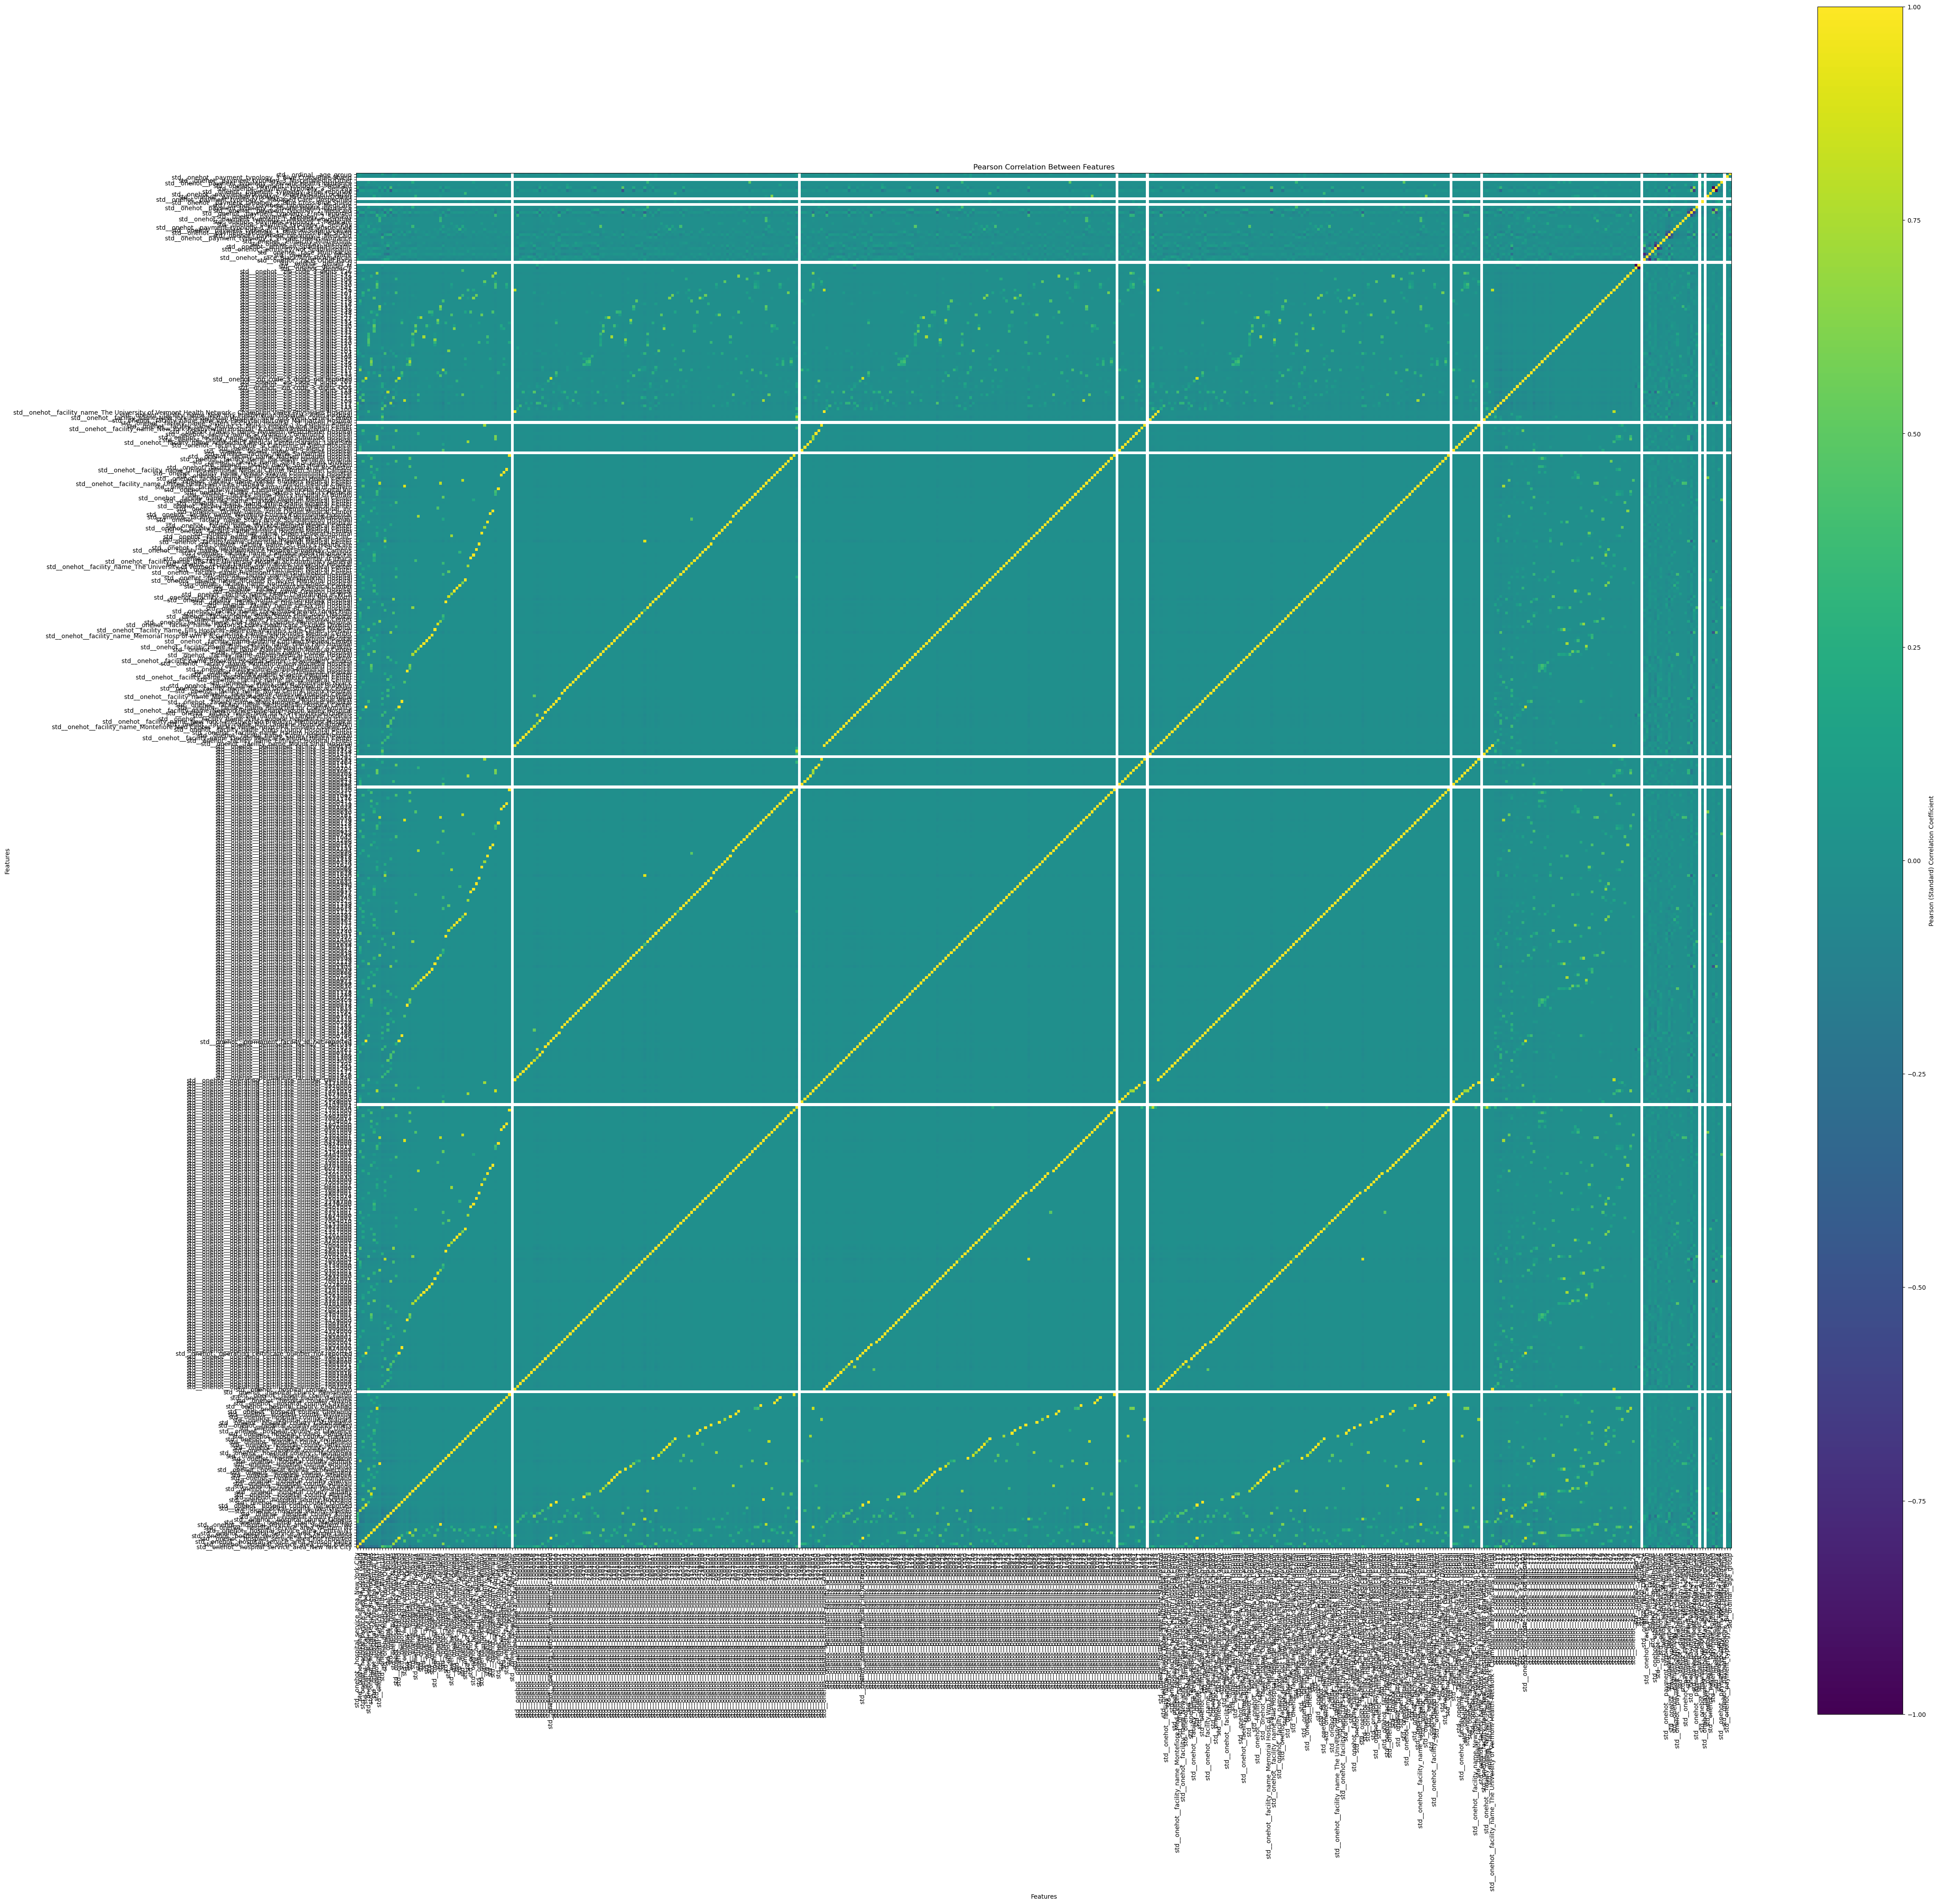

In [24]:
corr_matrix = pd.DataFrame(X_test, columns=prep_ftrs).corr(method='pearson')
        
plt.figure(figsize=(50, 50))
plt.imshow(corr_matrix, origin='lower', vmin=-1, vmax=1)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Pearson Correlation Between Features')
plt.xticks(ticks=range(0, len(corr_matrix.columns)), labels=corr_matrix.columns, rotation='vertical')
plt.yticks(ticks=range(0, len(corr_matrix.columns)), labels=corr_matrix.columns)
plt.colorbar(label='Pearson (Standard) Correlation Coefficient')
plt.show()
# look into annotations

In [25]:
X.columns

Index(['hospital_service_area', 'hospital_county',
       'operating_certificate_number', 'permanent_facility_id',
       'facility_name', 'age_group', 'zip_code_3_digits', 'gender', 'race',
       'ethnicity', 'payment_typology_1', 'payment_typology_2',
       'payment_typology_3'],
      dtype='object')

In [31]:
import seaborn as sns

In [70]:
len(prep_ftrs)

498

In [48]:
corr_matrix = pd.DataFrame(X_test, columns=prep_ftrs).corr(method='pearson')

In [49]:
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")

In [50]:
sorted_pairs

std__onehot__gender_M                         std__onehot__gender_F                                                        -1.000000
std__onehot__gender_F                         std__onehot__gender_M                                                        -1.000000
std__onehot__payment_typology_3_not reported  std__onehot__payment_typology_3_Self-Pay                                     -0.985589
std__onehot__payment_typology_3_Self-Pay      std__onehot__payment_typology_3_not reported                                 -0.985589
std__onehot__ethnicity_Not Span/Hispanic      std__onehot__ethnicity_Spanish/Hispanic                                      -0.786773
                                                                                                                              ...   
std__ordinal__age_group                       std__onehot__facility_name_Sisters of Charity Hospital - St. Joseph Campus         NaN
                                              std__onehot__gender_U  

In [64]:
high_pos_correlation = sorted_pairs[sorted_pairs > 0.97]

In [69]:
high_pos_correlation

std__onehot__hospital_county_St Lawrence                 std__onehot__permanent_facility_id_000815                  0.980449
std__onehot__facility_name_Canton-Potsdam Hospital       std__onehot__hospital_county_St Lawrence                   0.980449
std__onehot__hospital_county_St Lawrence                 std__onehot__operating_certificate_number_4429000          0.980449
                                                         std__onehot__facility_name_Canton-Potsdam Hospital         0.980449
std__onehot__permanent_facility_id_000815                std__onehot__hospital_county_St Lawrence                   0.980449
                                                                                                                      ...   
std__ordinal__age_group                                  std__ordinal__age_group                                    1.000000
std__onehot__operating_certificate_number_7000024        std__onehot__facility_name_North Central Bronx Hospital    1.000000


In [66]:
high_neg_correlation = sorted_pairs[sorted_pairs < -0.97]

In [67]:
high_neg_correlation

std__onehot__gender_M                         std__onehot__gender_F                          -1.000000
std__onehot__gender_F                         std__onehot__gender_M                          -1.000000
std__onehot__payment_typology_3_not reported  std__onehot__payment_typology_3_Self-Pay       -0.985589
std__onehot__payment_typology_3_Self-Pay      std__onehot__payment_typology_3_not reported   -0.985589
dtype: float64

In [29]:
pd.DataFrame(X_test, columns=prep_ftrs).corrwith(hos_service_area_ftrs, method='pearson', axis=0)

std__onehot__hospital_service_area_New York City      1.0
std__onehot__hospital_service_area_Long Island        1.0
std__onehot__hospital_service_area_Hudson Valley      1.0
std__onehot__hospital_service_area_not reported       1.0
std__onehot__hospital_service_area_Capital/Adirond    1.0
                                                     ... 
std__onehot__zip_code_3_digits_148                    NaN
std__onehot__zip_code_3_digits_149                    NaN
std__onehot__zip_code_3_digits_OOS                    NaN
std__onehot__zip_code_3_digits_not reported           NaN
std__ordinal__age_group                               NaN
Length: 498, dtype: float64

# Best Model - Local Feature Importance (SHAP)